In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.problems.multifidelity_functions import Forrester_1b
from mfbml.methods.mfrbfkriging import MFRBFKriging
from mfpml.models.co_kriging import CoKriging
from mfpml.models.hierarchical_kriging import HierarchicalKriging
from mfpml.models.mf_scale_kriging import ScaledKriging

# import accuracy metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## noise less 1 D case for illustration


In [2]:
# define function
func = Forrester_1b()
# define sampler
sampler = MFSobolSequence(design_space=func.design_space, seed=1)
sample_x = sampler.get_samples(num_hf_samples=4, num_lf_samples=11)
# update sample_x['hf']
sample_x["hf"] = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))

# get response
sample_y = func(sample_x)
# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

### developed method


In [7]:
# define kernel
start_time = time.time()
mfrbfkriging_model = MFRBFKriging(
    design_space=func.input_domain, optimizer_restart=20)
mfrbfkriging_model.train(samples=sample_x, responses=sample_y)
pred_y, pred_std = mfrbfkriging_model.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly = mfrbfkriging_model.predict_lf(test_xl=test_x)
end_time = time.time()
print("time: ", end_time - start_time)

# calculate accuracy metrics
mse = mean_squared_error(test_hy, pred_y)
mae = mean_absolute_error(test_hy, pred_y)
r2 = r2_score(test_hy, pred_y)
cpu_time = end_time - start_time
print("mse: ", mse)
print("mae: ", mae)
print("r2: ", r2)
print("cpu_time: ", cpu_time)

time:  0.35543012619018555
mse:  0.0037073916804329795
mae:  0.047979802716791725
r2:  0.9998142531670344
cpu_time:  0.35543012619018555


## HK method


In [8]:
# train model
start_time = time.time()
hk_model = HierarchicalKriging(
    design_space=func.input_domain, optimizer_restart=20)
hk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
hk_pred_ly = hk_model.predict_lf(test_xl=test_x)
# get prediction of high fidelity
hk_pred_hy, hk_pred_std = hk_model.predict(x_predict=test_x, return_std=True)
end_time = time.time()
# calculate accuracy metrics
mse = mean_squared_error(test_hy, hk_pred_hy)
mae = mean_absolute_error(test_hy, hk_pred_hy)
r2 = r2_score(test_hy, hk_pred_hy)
cpu_time = end_time - start_time

# print accuracy metrics
print("mse: ", mse)
print("mae: ", mae)
print("r2: ", r2)
print("cpu_time: ", cpu_time)

mse:  0.012249996270401941
mae:  0.0663502475325685
r2:  0.9993862536771939
cpu_time:  0.48671698570251465


In [9]:
# co-kriging
strat_time = time.time()
ck_model = CoKriging(design_space=func.input_domain, optimizer_restart=20)
ck_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
ck_pred_ly = ck_model.predict_lf(test_xl=test_x)
# get prediction of high fidelity
ck_pred_hy, ck_pred_std = ck_model.predict(x_predict=test_x, return_std=True)
end_time = time.time()

# calculate accuracy metrics
mse = mean_squared_error(test_hy, ck_pred_hy)
mae = mean_absolute_error(test_hy, ck_pred_hy)
r2 = r2_score(test_hy, ck_pred_hy)
cpu_time = end_time - start_time

# print accuracy metrics
print("mse: ", mse)
print("mae: ", mae)
print("r2: ", r2)
print("cpu_time: ", cpu_time)

mse:  0.011575018275526643
mae:  0.0648335190256185
r2:  0.9994200712599249
cpu_time:  13.81460452079773


In [10]:
# scaled kriging
start_time = time.time()
sk_model = ScaledKriging(design_space=func.input_domain, optimizer_restart=20)
sk_model.train(samples=sample_x, responses=sample_y)
# get prediction of low fidelity
sk_pred_ly = sk_model.predict_lf(test_xl=test_x)
# get prediction of high fidelity
sk_pred_hy, sk_pred_std = sk_model.predict(x_predict=test_x, return_std=True)
end_time = time.time()

# calculate accuracy metrics
mse = mean_squared_error(test_hy, sk_pred_hy)
mae = mean_absolute_error(test_hy, sk_pred_hy)
r2 = r2_score(test_hy, sk_pred_hy)
cpu_time = end_time - start_time

# print accuracy metrics
print("mse: ", mse)
print("mae: ", mae)
print("r2: ", r2)
print("cpu_time: ", cpu_time)

mse:  6.053615986348663
mae:  1.824238602645063
r2:  0.6967032095937187
cpu_time:  0.4596669673919678


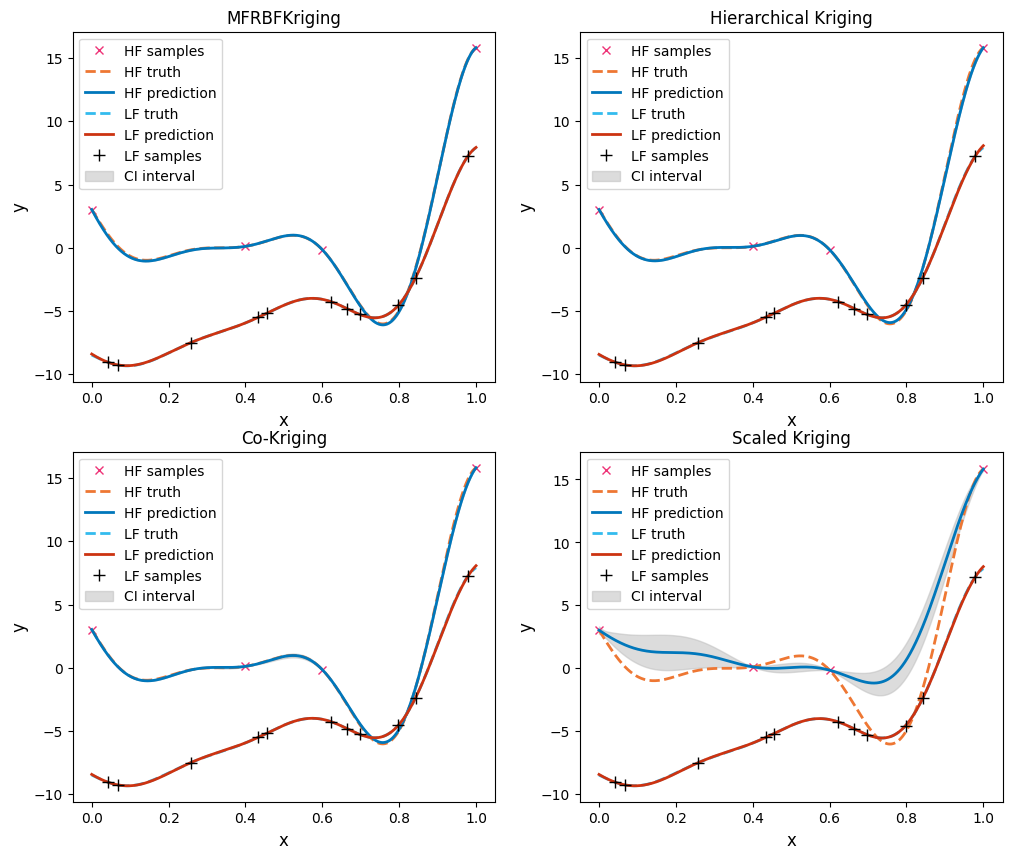

In [11]:
# plot results in 2x2 grid
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[0, 0].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[0, 0].plot(test_x, pred_y, "-", color="#0077BB",
              linewidth=2, label="HF prediction")
ax[0, 0].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[0, 0].plot(test_x, pred_ly, "-", color="#CC3311",
              linewidth=2, label="LF prediction")
ax[0, 0].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[0, 0].fill_between(
    test_x.flatten(),
    (pred_y - 2 * pred_std).flatten(),
    (pred_y + 2 * pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0, 0].set_title("MFRBFKriging")
ax[0, 0].set_ylabel("y", fontsize=12)
ax[0, 0].set_xlabel("x", fontsize=12)
ax[0, 0].legend()
# for hierarchical kriging
ax[0, 1].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[0, 1].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[0, 1].plot(
    test_x, hk_pred_hy, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[0, 1].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[0, 1].plot(
    test_x, hk_pred_ly, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[0, 1].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[0, 1].fill_between(
    test_x.flatten(),
    (hk_pred_hy - 2 * hk_pred_std).flatten(),
    (hk_pred_hy + 2 * hk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0, 1].set_title("Hierarchical Kriging")
ax[0, 1].set_ylabel("y", fontsize=12)
ax[0, 1].set_xlabel("x", fontsize=12)
ax[0, 1].legend()
# for co-kriging
ax[1, 0].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[1, 0].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[1, 0].plot(
    test_x, ck_pred_hy, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[1, 0].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[1, 0].plot(
    test_x, ck_pred_ly, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[1, 0].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[1, 0].fill_between(
    test_x.flatten(),
    (ck_pred_hy - 2 * ck_pred_std).flatten(),
    (ck_pred_hy + 2 * ck_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1, 0].set_title("Co-Kriging")
ax[1, 0].set_ylabel("y", fontsize=12)
ax[1, 0].set_xlabel("x", fontsize=12)
ax[1, 0].legend()
# for scaled kriging
ax[1, 1].plot(
    sample_x["hf"],
    sample_y["hf"],
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=6,
    label="HF samples",
)
ax[1, 1].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF truth")
ax[1, 1].plot(
    test_x, sk_pred_hy, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[1, 1].plot(test_x, test_ly, "--", color="#33BBEE",
              linewidth=2, label="LF truth")
ax[1, 1].plot(
    test_x, sk_pred_ly, "-", color="#CC3311", linewidth=2, label="LF prediction"
)
ax[1, 1].plot(
    sample_x["lf"],
    sample_y["lf"],
    "k+",
    linewidth=2,
    markersize=8,
    label="LF samples",
)
ax[1, 1].fill_between(
    test_x.flatten(),
    (sk_pred_hy - 2 * sk_pred_std).flatten(),
    (sk_pred_hy + 2 * sk_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[1, 1].set_title("Scaled Kriging")
ax[1, 1].set_ylabel("y", fontsize=12)
ax[1, 1].set_xlabel("x", fontsize=12)
ax[1, 1].legend()
# plt.tight_layout()
plt.savefig("test_idea.pdf", bbox_inches="tight", dpi=300)
plt.show()
# plt.savefig("test_idea.png")